In [57]:
try:
    import matplotlib.pyplot as plt
    from datasets import load_dataset
    from comet_ml import start
    from comet_ml.integration.pytorch import log_model
    from sklearn.model_selection import train_test_split
    from copy import deepcopy
    import numpy as np
    import umap
    import torch
    import torch.nn as nn
except:
    import os
    os.system("pip install datasets comet_ml umap_learn")

In [58]:
sample_size = 1024

In [59]:
data = load_dataset("Artificio/WikiArt_Full")['train']

genres, styles, image_refs = data['genre'][:sample_size], data['style'][:sample_size], data['image'][:sample_size]

In [60]:
# czytanie zdjec
images = torch.Tensor(np.array(image_refs))

mask = torch.zeros_like( torch.Tensor(images.shape[:-1]) ).unsqueeze(3) # pierwsze 3 wymiary takie same tylko ostatni na 1 tak zeby go dodac jako dodatkowy do RGB
images = torch.cat([images, mask], dim=-1) / 255. # maska i normalizacja

if images.shape[1] == 256: # zamiana wymiarow zeby najpierw kanaly szli na conva
    images = images.permute(0, 3, 1, 2) # N probek, kanaly, wysokosc, szerokosc

non_testing_images, images_test = train_test_split(images, test_size=0.2, shuffle=False)
images_train, images_validate = train_test_split(non_testing_images, test_size=0.2, shuffle=False) # shuffle=False zeby autoencoder nie dostal testowych danych i ich nie dekodowal przez przypadek

Czesc nieusunieta regular_slicing_image_comparison jest 16.00 razy wieksza od czesci usunietej.
Czesc nieusunieta irregular_slicing_image_comparison jest 18.70 razy wieksza od czesci usunietej.


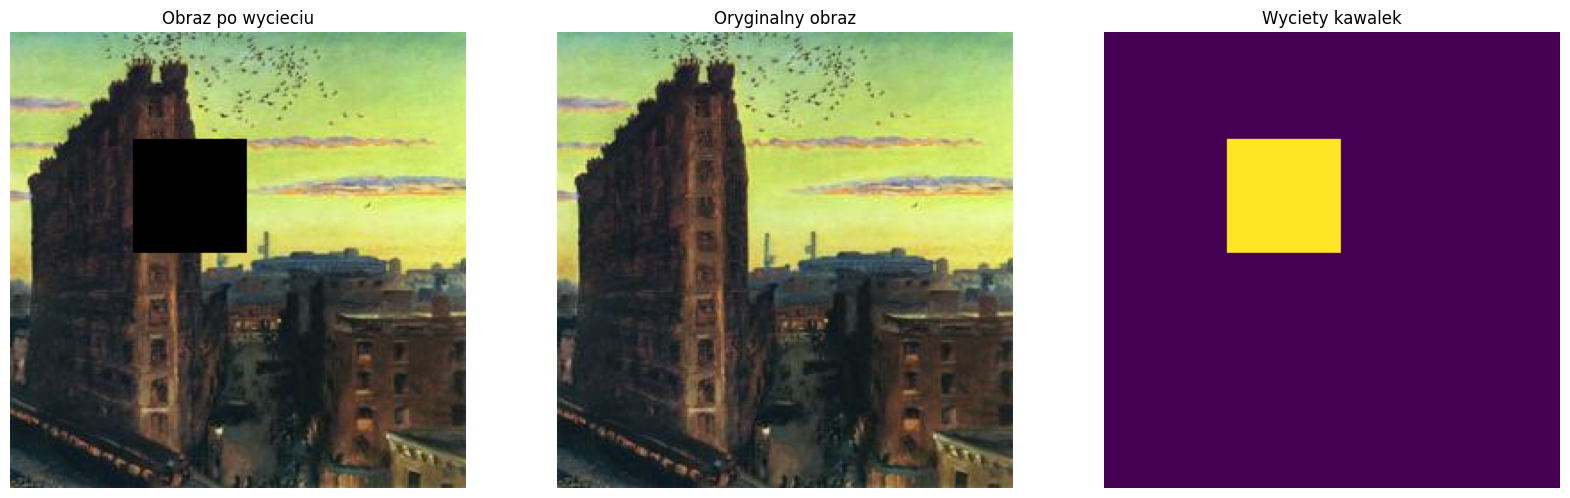

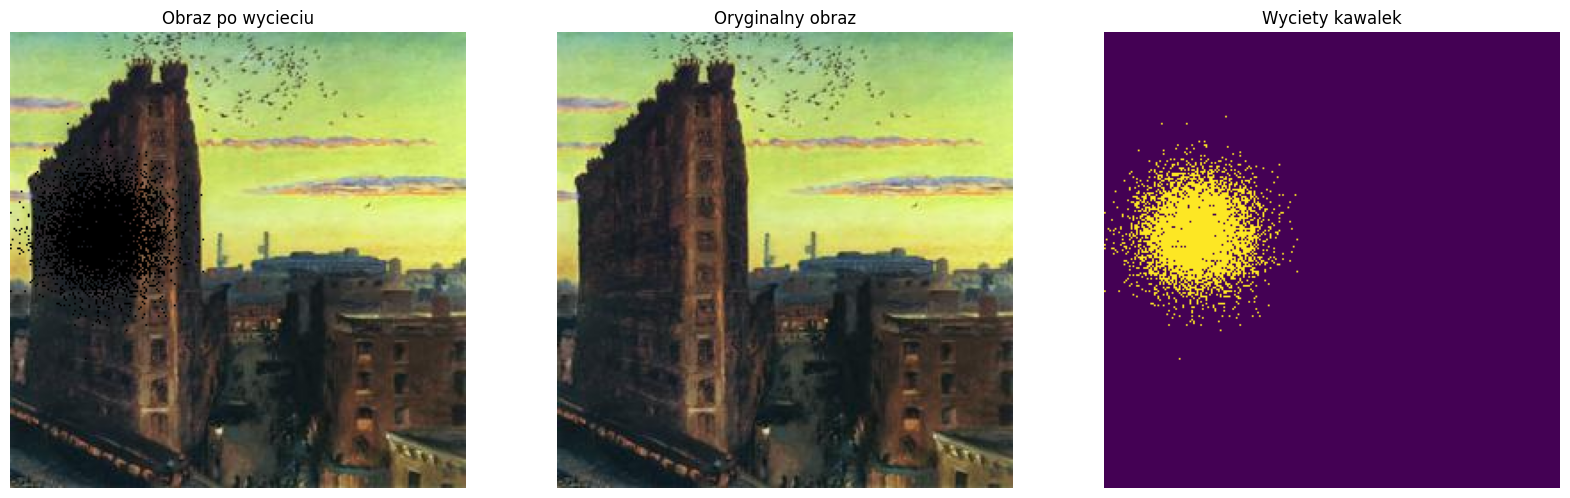

In [61]:
def regular_cut(images):
    BATCH, C, H, W = images.shape
    size_h, size_w = H // 4, W // 4
    
    starts = (torch.rand(BATCH, 2) * torch.tensor([H - size_h, W - size_w])).long() # indeksy startowe od ktorych usuwane beda pixele
    
    h_offsets = torch.arange(size_h).view(-1, 1)
    w_offsets = torch.arange(size_w).view(1, -1)
    
    h_indx = starts[:, 0].view(BATCH, 1, 1) + h_offsets
    w_indx = starts[:, 1].view(BATCH, 1, 1) + w_offsets
    
    images_to_ret = images.clone()
    
    images_to_ret[:, :-1, h_indx, w_indx] = 0.
    images_to_ret[:,  -1, h_indx, w_indx] = 1.
    
    return images_to_ret


def irregular_cut(images):
    BATCH, _, H, W = images.shape
    cut_points_num = (H * W) // 8 # 1/8 punktow zostanie usunieta z kazdego z obrazow, ale beda sie nachodzic i wyjdzie ok. 1/18
    
    centers = torch.rand(BATCH, 1, 2) * torch.tensor([H, W])  # (BATCH, 1, 2)
    
    scaling = H // 16
    offsets = torch.randn(BATCH, cut_points_num, 2) * scaling  # (BATCH, num_points, 2)
    indices_to_cut = (offsets + centers).long() % torch.tensor([H, W]) # (BATCH, num_points, 2)
    
    h_indices = indices_to_cut[:, :, 0]  # Indeksy na wysokosci na jakich beda usuwane pixele (BATCH, 2)
    w_indices = indices_to_cut[:, :, 1]  # Indeksy na szerokosci na jakich beda usuwane pixele (BATCH, 2)
    
    images_to_ret = images.clone()

    images_to_ret[:, :-1, h_indices , w_indices] = 0.
    images_to_ret[:, -1, h_indices, w_indices] = 1.
    
    return images_to_ret


def plot_and_compare(image_cut, fig_name = 'Wykresy'):
    cut_layer = image_cut[:,:,-1].cpu().detach().numpy() # zobaczyc co sie wycielo
    image_cut = (image_cut[:,:,:-1].cpu().detach().numpy() * 255).astype('uint8') # do numpy'a i skalowanie
    
    print(f'Czesc nieusunieta {fig_name} jest {cut_layer.size / cut_layer.sum() :.2f} razy wieksza od czesci usunietej.')

    fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, nrows=1, figsize=(20, 15))

    ax1.set_title('Obraz po wycieciu')
    ax1.imshow(image_cut)
    ax1.axis('off')

    ax2.set_title('Oryginalny obraz')
    ax2.imshow(np.array(image_refs[0]))
    ax2.axis('off')

    ax3.set_title('Wyciety kawalek')
    ax3.imshow(cut_layer)
    ax3.axis('off')
    plt.savefig(f'./plots/{fig_name}.png')


image_cut = regular_cut(images_train[0:1]).permute(0, 2, 3, 1).squeeze()
plot_and_compare(image_cut, 'regular_slicing_image_comparison')

image_cut = irregular_cut(images_train[0:1]).permute(0, 2, 3, 1).squeeze()
plot_and_compare(image_cut, 'irregular_slicing_image_comparison')

In [ ]:
def make_decoder(encoder):
    decoder = nn.Sequential()

    for encoder_layer in reversed(encoder): # odwracanie dzialania encodera
        if isinstance(encoder_layer, nn.Conv2d):
            to_append = nn.ConvTranspose2d(encoder_layer.out_channels, encoder_layer.in_channels, encoder_layer.kernel_size, encoder_layer.stride, encoder_layer.padding, encoder_layer.dilation)
        elif isinstance(encoder_layer, nn.MaxPool2d) or isinstance(encoder_layer, nn.AvgPool2d):
            to_append = nn.ConvTranspose2d(3, 3, kernel_size=encoder_layer.kernel_size, stride=encoder_layer.stride) # mogloby tu wejsc jeszcze Upscaling lob unpooling ale tamte dwa sie nie ucza
        else:
            to_append = deepcopy(encoder_layer) # najpewniej jest tu funkcja aktywacji
        decoder.append(to_append)

    return decoder

class Autoencoder(nn.Module):
    def __init__(self, encoder_layers: list[nn.Module], lr, decoder_out_channels: list[int] = None):
        super().__init__()
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = make_decoder(self.encoder)
        
        self.optim = torch.optim.Adam(self.parameters(), lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, input):
        input = input.to(self.device)
        return self.decoder( self.encoder(input) )
    
    def update_weights(self, input):
        input = input.to(self.device)
        autoencoder.zero_grad()
        image_reconstructed = autoencoder(input)
        loss = autoencoder.loss(input, image_reconstructed)
        loss.backward() 
        autoencoder.optim.step()
        return loss.item()


# zeby stride nie zmienil wymiarow musi spelnione byc 1 - stride <= 2 * padding - dilation * (kernel - 1) < 1
# najlatwiej spelnic dla kernel = 2 * padding + 1 i dilation = default
encoder_layers = [
    nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
]


ENCODER_EPOCHS = 250
BATCH_SIZE = 128
learning_rate = 2.5e-4
autoencoder = Autoencoder(encoder_layers, images_train.shape[1:], learning_rate) # [1:] - bo liczba obrazow / batch nas nie interesuje

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

images_train = images_train.to(device)
images_test = images_test.to(device)
autoencoder = autoencoder.to(device)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(images_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(images_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

experiment = start(
    api_key="e3sbMUovSj6iwJeFr3Mr3H4wa",
    project_name="unsupervised-learning-studies",
    workspace="damianmendel"
)

parameters = {
    'learning_rate': learning_rate,
    'epochs': ENCODER_EPOCHS,
    'batch_size': BATCH_SIZE,
    'encoder': autoencoder.encoder, # dekodujace warstwy takie same tylko convTranspose 
    'decoder': autoencoder.decoder,
    'optimizer': autoencoder.optim,
    'loss_function': autoencoder.loss
}

# trening
for epoch in range(ENCODER_EPOCHS):
    progress = (epoch + 1) / ENCODER_EPOCHS * 100
    print(f'\rProgress: {progress:.1f}% (Epoch {epoch + 1}/{ENCODER_EPOCHS})', end='', flush=True)
    
    for [batch] in train_dataloader: # dataloader zawsze zwraca liste
        batch = batch.to(device)
        autoencoder.update_weights(batch)
        # na pocietych zdjeciach nie trzeba autoencodera jednak trenowac powinien sie nauczyc na zwyklych - Luczak mowil

    if epoch % 10 == 0:
        with torch.no_grad():
            test_losses = []
            for [test_batch] in test_dataloader:
                test_batch = test_batch.to(device)
                predicted = autoencoder(test_batch)
                test_loss = autoencoder.loss(predicted, test_batch)
                test_losses.append(test_loss.item())
            avg_test_loss = sum(test_losses) / len(test_losses)
            print(f'\rProgress: {progress:.1f}% (Epoch {epoch + 1}/{ENCODER_EPOCHS}) - Test Loss: {avg_test_loss:.6f}', end='', flush=True)
        
torch.save(autoencoder.state_dict(), './models/autoencoder.pth')

experiment.log_model("Ending_model", './models/autoencoder.pth')

experiment.end()

Sequential(
  (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): ReLU()
)
Sequential(
  (0): ReLU()
  (1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (2): ReLU()
  (3): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)
Oryginalny wymiar obrazu 256
Po 1 warstwie encodera rozmiar obrazu: 128
Po 3 warstwie encodera rozmiar obrazu: 64
Po 5 warstwie encodera rozmiar obrazu:

COMET INFO: An experiment with the same configuration options is already running and will be reused.


Progress: 100.0% (Epoch 250/250)- Test Loss: 0.011978

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : nursing_clownfish_5672
COMET INFO:     url                   : https://www.comet.com/damianmendel/unsupervised-learning-studies/a558dc2a7a574cb4999e8eaf36bd48cf
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [150] : (0.010086347348988056, 0.23262730240821838)
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.89 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     model-element            : 1 (87.76 KB)
COMET INFO:     noteboo

In [66]:
predicted = autoencoder.encoder(test_batch)
predicted.shape

torch.Size([77, 4, 16, 16])